<a href="https://colab.research.google.com/github/DiaaEddinH/small-indiv-projects/blob/master/itemcomparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import json, requests

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/"

In [35]:
rename_dict = {
 "FlatHPPoolMod":"hp",
 "FlatMPPoolMod":"mp",
 "PercentHPPoolMod":"hp%",
 "PercentMPPoolMod":"mp%",
 "FlatHPRegenMod":"hpregen",
 "PercentHPRegenMod":"hpregen%",
 "FlatMPRegenMod":"mpregen",
 "PercentMPRegenMod":"mpregen%",
 "FlatArmorMod":"armor",
 "rFlatArmorPenetrationMod":"armorpen",
 "rPercentArmorPenetrationMod":"armorpen%",
 "FlatPhysicalDamageMod":"attackdamage",
 "PercentPhysicalDamageMod":"attackdamage%",
 "FlatMagicDamageMod":"magicdamage",
 "PercentMagicDamageMod":"magicdamage%",
 "FlatMovementSpeedMod":"movespeed",
 "PercentMovementSpeedMod":"movespeed%",
 "PercentAttackSpeedMod":"attackspeed",
 "FlatCritChanceMod":"crit",
 "PercentCritDamageMod":"crit_mult",
 "FlatBlockMod":"block",
 "PercentBlockMod":"block%",
 "FlatSpellBlockMod":"spellblock",
 "PercentSpellBlockMod":"spellblock%",
 "rFlatMagicPenetrationMod":"spellpen",
 "rPercentMagicPenetrationMod":"spellpen%",
 "PercentLifeStealMod":"lifesteal",
 "PercentSpellVampMod":"spellvamp"
 }

In [36]:
champ_res = requests.get('https://ddragon.leagueoflegends.com/cdn/12.13.1/data/en_US/champion.json')
item_res = requests.get('https://ddragon.leagueoflegends.com/cdn/12.13.1/data/en_US/item.json')
# rename_dict = {
#   'FlatMovementSpeedMod':'movespeed',
#   'FlatHPPoolMod':'hp',
#   'FlatCritChanceMod':'crit',
#   'FlatMagicDamageMod':'magicdamage',
#   'FlatMPPoolMod':'mp',
#   'FlatArmorMod':'armor',
#   'FlatSpellBlockMod':'spellblock',
#   'FlatPhysicalDamageMod':'attackdamage',
#   'PercentAttackSpeedMod':'attackspeed',
#   'FlatHPRegenMod':'hpregen',
#   'PercentLifeStealMod':'lifesteal',
#   'PercentMovementSpeedMod':'movespeed%'
#   }

item_dict = {v['name']:v['stats'] for k,v in item_res.json()['data'].items() if v['stats']}
item_dict = pd.DataFrame.from_dict(item_dict).fillna(0).rename(index=rename_dict).to_dict()

In [37]:
df = pd.DataFrame.from_dict(item_dict).fillna(0).rename(index=rename_dict)

In [ ]:
for k,v in item_res.json()['data'].items():
  print(v['name'], v['stats'])

In [66]:
d = pd.DataFrame.from_dict(v['stats']).rename_dict(index=rename_dict)

ValueError: ignored

In [15]:
class Item:  
  def __init__(self, item_name:str) -> None:
    self.__dict__.update(item_dict[item_name])
    self.__dict__['attackrange'] = 0
    self.__dict__['mpregen'] = 0
    self.name = item_name
    self.PASSIVES = dict()
  
  def passive(self,func):
    self.PASSIVES[func.__name__] = func
    return func

In [42]:
#Create a class of champions using the stats obtained from Riot's API
class Champion:
  """Class to define champion with their name. Gets and loads champion's stats using Riot's API"""

  def __init__(self, champ_name:str) -> None:
    #Save stats in class object dictionary
    self.__dict__.update(champ_res.json()['data'][champ_name]['stats'])
    self.__dict__['magicdamage'] = 0
    self.__dict__['lethality'] = 0
    self.__dict__['armorpen%'] = 0
    self.__dict__['magicdamageperlevel'] = 0
    self.__dict__['movespeedperlevel'] = 0
    self.__dict__['attackrangeperlevel'] = 0

    #Separate base stats from growth statistics
    self.base = {k:v for k,v in self.__dict__.items() if 'perlevel' not in k}
    self.growth = {k:v for k,v in self.__dict__.items() if 'perlevel' in k}

    #Set rest of parameters
    self.name = champ_name
    self.lvl = 1
    self.crit_mult = 1.75
    #Set dicts to save passive functions and item class objects
    self.PASSIVES = dict()
    self.ITEMS = dict()
  
  def set_level(self, level) -> None:
    """Levels up champion, adjusting stats from growth"""
    assert (level > 0 and level < 19), 'Level must be in range [1,18]'
    assert isinstance(level,int), 'Level must be an integer'

    self.lvl = level
    for key in self.base.keys():
      self.__dict__[key] = self.stat_growth(key)

  def auto(self) -> float:
    """Simulates auto-attacking once"""
    r = np.random.uniform(0,1)
    if r < self.crit:
      return self.attackdamage * self.crit_mult
    else:
      return self.attackdamage
  
  def auto_n_times(self, n_times:int) -> float:
    """Simulates auto-attacking (n) number of times"""
    return sum(self.auto() for i in range(n_times))
  
  def stat_growth(self, stat) -> float:
    """Uses riot's formula to calculate statistics growth"""
    if stat == 'attackspeed':
      out = self.base[stat]*(1 + 0.01*self.growth[stat+'perlevel']*(self.lvl-1)*(0.7025 + 0.0175*(self.lvl-1)))
      return round(out,4)
    else:
      out = self.base[stat] + self.growth[stat+'perlevel']*(self.lvl-1)*(0.7025 + 0.0175*(self.lvl-1))
      return round(out,2)
  
  def passive(self,func):
    self.PASSIVES[func.__name__] = func
    return func

  #Currently, cannot add duplicates of an item, whether it be basic or legendary.
  #For most purposes, this is for the best. Changing storage from dict to list may be an idea.
  def add_item(self, item_name:str) -> None:
    assert item_name not in self.ITEMS, 'You may have only one of each item in your inventory'

    self.ITEMS[item_name] = Item(item_name) #Store item in dict
    #Update stat change
    for key in self.ITEMS[item_name].__dict__.keys():
      if key in self.base:
        if key == 'attackspeed':
          self.__dict__[key] += self.ITEMS[item_name].__dict__[key] * self.base[key]
        else:
          self.__dict__[key] += self.ITEMS[item_name].__dict__[key]
      else:
        self.__dict__[key] = self.ITEMS[item_name].__dict__[key]


  def remove_item(self, item_name:str) -> None:
    assert item_name in self.ITEMS, 'This item is not in your inventory'
    #Update stat change  
    for key in self.ITEMS[item_name].__dict__.keys():
      if key == 'attackspeed':
        self.__dict__[key] -= self.ITEMS[item_name].__dict__[key] * self.base[key]
      else:
        self.__dict__[key] -= self.ITEMS[item_name].__dict__[key]
    
    del self.ITEMS[item_name]  #Remove item from dict

In [43]:
champ_name = 'Tristana'
item_name = "Warmog's Armor"
champ = Champion(champ_name)

In [44]:
Item(item_name).__dict__.keys()

dict_keys(['movespeed', 'hp', 'crit', 'magicdamage', 'mp', 'armor', 'spellblock', 'attackdamage', 'attackspeed', 'lifesteal', 'hpregen', 'movespeed%', 'attackrange', 'mpregen', 'name', 'PASSIVES'])

In [45]:
champ.add_item("Lord Dominik's Regards")

In [46]:
champ.__dict__

{'ITEMS': {"Lord Dominik's Regards": <__main__.Item at 0x7fb606d02710>},
 'PASSIVES': {},
 'armor': 26.0,
 'armorpen%': 0,
 'armorperlevel': 4.2,
 'attackdamage': 89.0,
 'attackdamageperlevel': 3.7,
 'attackrange': 525,
 'attackrangeperlevel': 0,
 'attackspeed': 0.656,
 'attackspeedperlevel': 1.5,
 'base': {'armor': 26,
  'armorpen%': 0,
  'attackdamage': 59,
  'attackrange': 525,
  'attackspeed': 0.656,
  'crit': 0,
  'hp': 670,
  'hpregen': 4,
  'lethality': 0,
  'magicdamage': 0,
  'movespeed': 325,
  'mp': 250,
  'mpregen': 7.2,
  'spellblock': 30},
 'crit': 0.2,
 'crit_mult': 1.75,
 'critperlevel': 0,
 'growth': {'armorperlevel': 4.2,
  'attackdamageperlevel': 3.7,
  'attackrangeperlevel': 0,
  'attackspeedperlevel': 1.5,
  'critperlevel': 0,
  'hpperlevel': 102,
  'hpregenperlevel': 0.65,
  'magicdamageperlevel': 0,
  'movespeedperlevel': 0,
  'mpperlevel': 32,
  'mpregenperlevel': 0.45,
  'spellblockperlevel': 1.3},
 'hp': 670.0,
 'hpperlevel': 102,
 'hpregen': 4.0,
 'hpregenper

In [ ]:
import functools

def decorator(func):
  @functools.wraps(func)
  def wrapper_decorator(*args,**kwargs):
    value = func(*args,**kwargs)
    
    return value
  return wrapper_decorator

In [41]:
@champ.passive
def rage(crit):
  return 200*crit

In [42]:
champ.PASSIVES['rage'].__code__.co_varnames

('crit',)

In [ ]:
class Champ:
  def __init__(self, hp, ar:float=0., mr:float=0.):
    self.hp = hp
    self.ar = ar
    self.mr = mr

  
class Item:
  def __init__(self, lvl, ad, arpen, leth, mana:float = 0):
    self.lvl = lvl
    self.ad = ad + 58 + (lvl-1)*2
    self.arpen = arpen
    self.leth = leth
    self.mana = 300 + 35*(lvl-1) + 250 + mana #MF's mana plus manaflow band
    
  def lvl_up(self):
    self.lvl = self.lvl + 1
    self.ad = self.ad + 2

  #Muramana Effects
  # def awe(self):
  #   self.ad = self.ad + 0.025*self.mana
  # def shock(self, auto: bool):
  #   if auto:
  #     return 0.015*self.mana + 0.06*self.ad
  #   else:
  #     return 0.027*self.mana + 0.06*self.ad

def dmg_received(raw_dmg, dmg_receiver: Champ, dmg_dealer: Item):
  flat_pen = dmg_dealer.leth*(0.6 + 0.4*dmg_dealer.lvl/18) 
  eff_armor = (dmg_receiver.ar * (1 - dmg_dealer.arpen)) - flat_pen

  if eff_armor < 0:
    eff_armor = 0

  return raw_dmg*100/(100 + eff_armor)  

def ldr_passive(hp_diff):
  return 1 + hp_diff*0.000075
  
def nilah_pen(crit,arpen):
  p_pen = 0.0033*crit

  return round(1 - (1-p_pen)*(1-arpen), 4)

In [ ]:
#General champion
N_hp = 41
N_ad = 11
Dummy = Champ(0, 0)

Collector = Item(1, ad=55, arpen=0, leth=12)
LDR = Item(1, ad=30, arpen=0.3, leth=0)

levels = np.linspace(1,18,18, dtype = int, endpoint=True)
base_ad = np.linspace(50,110, N_ad, endpoint=True)
armour = np.arange(30,210,10)
health = np.linspace(0, 1000, N_hp, endpoint=True)

ldr_res = np.zeros([18, N_ad, len(armour),N_hp])
coll_res = np.zeros([18, N_ad, len(armour),N_hp])

Collector = Item(1, ad=55, arpen=0, leth=12)
LDR = Item(1, ad=30, arpen=0.3, leth=0)

for lvl_idx, lvl_val in enumerate(levels):
  for ad_idx, ad_val in enumerate(base_ad):
    for ar_idx, ar_val in enumerate(armour):
      for hp_idx, hp_val in enumerate(health):
        Dummy = Champ(hp_val, ar_val)
        #Values rounded
        coll_res[lvl_idx,ad_idx,ar_idx,hp_idx] = round(dmg_received(Collector.ad + ad_val, Dummy, Collector))
        ldr_res[lvl_idx,ad_idx,ar_idx,hp_idx] = round(ldr_passive(Dummy.hp)*dmg_received(LDR.ad + ad_val, Dummy, LDR))
  Collector.lvl_up()
  LDR.lvl_up()

In [ ]:
dl = (coll_res/ldr_res)[12,:,:,0]

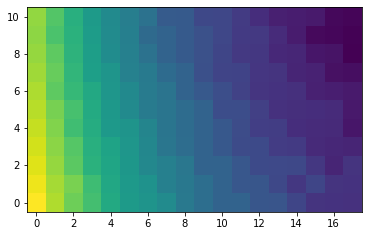

In [ ]:
plt.imshow(dl,origin=True)

Text(0.5, 1.0, 'Collector/LDR dmg ratio at lvl 13, 0 HP diff')

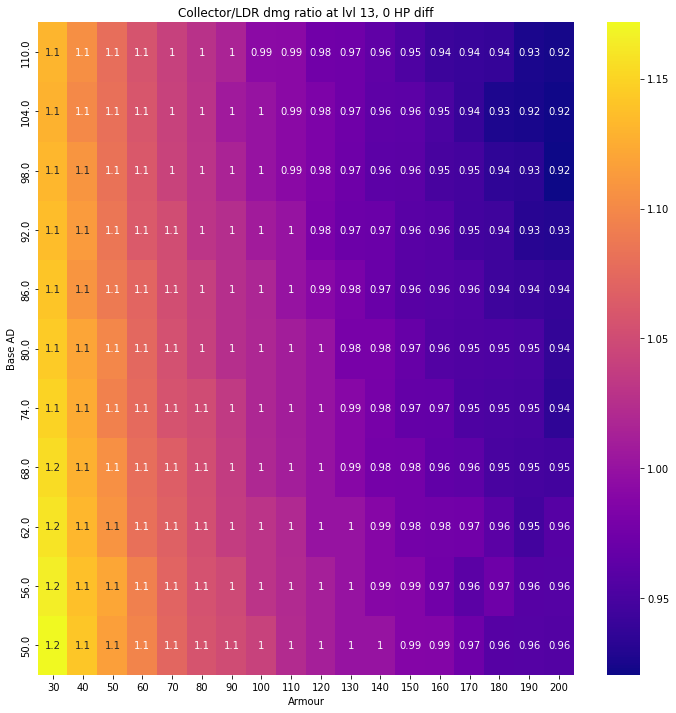

In [ ]:
extent = [armour[0],armour[-1],base_ad[0],base_ad[-1]]
fig,ax = plt.subplots(1,1,figsize=(12,12))
#ax = plt.subplot(111)
x,y = np.meshgrid(base_ad, armour)
s = sns.heatmap(dl,annot=True,
                cmap="plasma")
ax.set_xticklabels(armour)
ax.set_yticklabels(base_ad)
ax.invert_yaxis()
plt.ylabel("Base AD")
plt.xlabel("Armour")
plt.title("Collector/LDR dmg ratio at lvl 13, 0 HP diff")

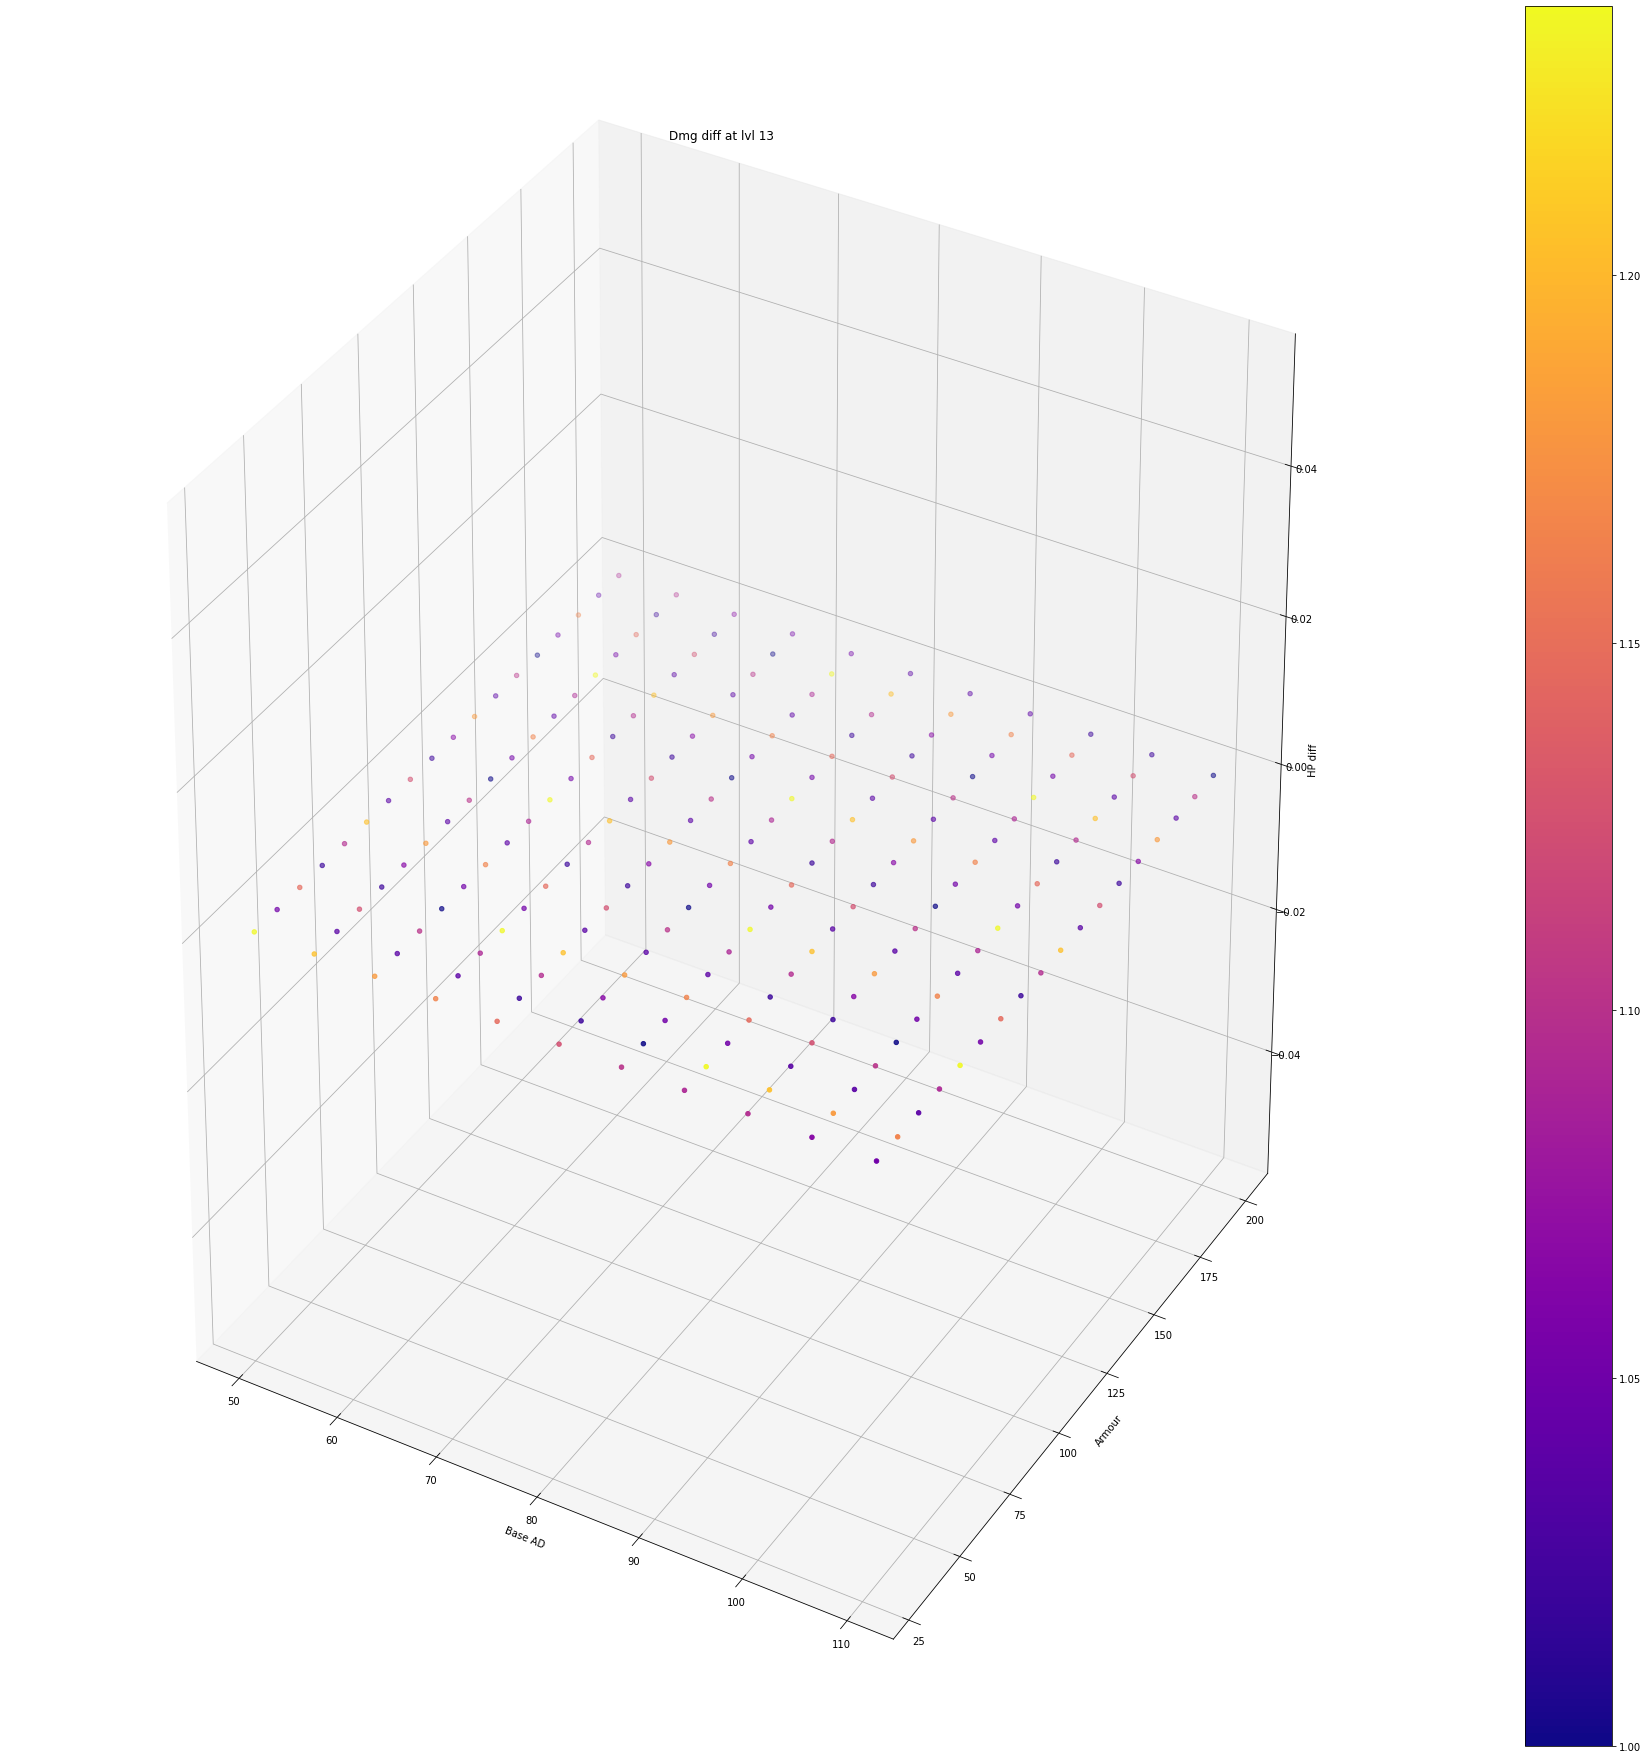

In [ ]:
fig = plt.figure(figsize=(32,32))
ax = fig.add_subplot(111, projection='3d')
x,y = np.meshgrid(base_ad, armour)
s = ax.scatter(x, y, c=dl, cmap='plasma')
plt.xlabel("Base AD")
plt.ylabel("Armour")
ax.set_zlabel("HP diff")
plt.title("Dmg diff at lvl 13")
fig.colorbar(s)

In [ ]:
#Collector
rows = []
for lvl_idx,lvl in enumerate(levels):
  for ad_idx,ad in enumerate(base_ad):
    for ar_idx,ar in enumerate(armour):
      for hp_idx,hp in enumerate(health):
        rows.append( [lvl, ad, ar, hp, coll_res[lvl_idx,ad_idx,ar_idx,hp_idx]])

df = pd.DataFrame( rows, columns=['LVL','AD','AR', 'HP','val'])
df

In [ ]:
#LDR
rows = []
for lvl_idx,lvl in enumerate(levels):
  for ad_idx,ad in enumerate(base_ad):
    for ar_idx,ar in enumerate(armour):
      for hp_idx,hp in enumerate(health):
        rows.append( [lvl, ad, ar, hp, ldr_res[lvl_idx,ad_idx,ar_idx,hp_idx]])

df = pd.DataFrame( rows, columns=['LVL','AD','AR','HP','val'])
df[df['AD']==100]

In [ ]:
#Collector/LDR ratio
rows = []
for lvl_idx,lvl in enumerate(levels):
  for ad_idx,ad in enumerate(base_ad):
    for ar_idx,ar in enumerate(armour):
      for hp_idx,hp in enumerate(health):
        rows.append( [lvl, ad, ar, hp, coll_res[lvl_idx,ad_idx,ar_idx,hp_idx]/ldr_res[lvl_idx,ad_idx,ar_idx,hp_idx]])

df = pd.DataFrame( rows, columns=['LVL','AD','AR','HP','val'])
df

,LVL,AD,AR,HP,val


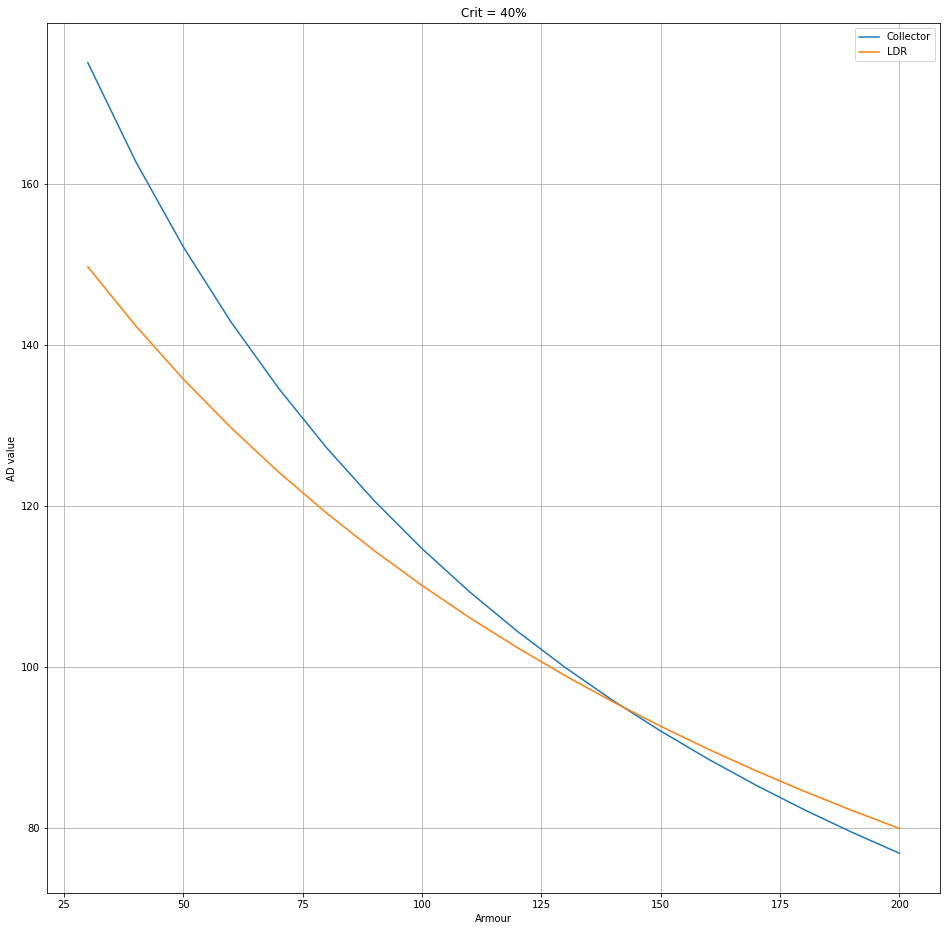

In [ ]:
crit_val = 40
Collector = Item(13, ad=55, arpen=0, leth=12)
LDR = Item(13, ad=30, arpen=0.3, leth=0)

Collector.ad += 55 + 10
LDR.ad += 55 + 10

#Nilah Q arpen
Collector.arpen = nilah_pen(crit_val, 0)
LDR.arpen = nilah_pen(crit_val, 0.3)

coll_factor = np.array([dmg_received(Collector.ad,Champ(0,i), Collector) for i in armour])
ldr_factor = np.array([dmg_received(LDR.ad,Champ(0,i), LDR) for i in armour])

plt.figure(figsize=(16,16))
plt.plot(armour, coll_factor, label="Collector")
plt.plot(armour, ldr_factor, label="LDR")
plt.xlabel("Armour")
plt.ylabel("AD value")
plt.title(f"Crit = {crit_val}%")
plt.legend()
plt.grid()

In [ ]:
N_hp = 41
Dummy = Champ(0, 0)

Collector = Item(1, ad=55, arpen=0, leth=12)
LDR = Item(1, ad=30, arpen=0.3, leth=0)

levels = np.linspace(1,18,18, dtype = int, endpoint=True)
crit = np.array([40,60,80,100])
armour = np.arange(30,210,10)
#armour = np.array([50,100,150,175])
health = np.linspace(0, 1000, N_hp, endpoint=True)

ldr_res = np.zeros([18, len(crit), len(armour),N_hp])
coll_res = np.zeros([18, len(crit), len(armour),N_hp])

Collector = Item(1, ad=55, arpen=0, leth=12)
LDR = Item(1, ad=30, arpen=0.3, leth=0)

for lvl_idx, lvl_val in enumerate(levels):
  for crit_idx, crit_val in enumerate(crit):
    Collector.arpen = nilah_pen(crit_val, 0)
    LDR.arpen = nilah_pen(crit_val, 0.3)
    for ar_idx, ar_val in enumerate(armour):
      for hp_idx, hp_val in enumerate(health):
        Dummy = Champ(hp_val, ar_val)
        #Values rounded
        coll_res[lvl_idx,crit_idx,ar_idx,hp_idx] = round(dmg_received(Collector.ad, Dummy, Collector))
        ldr_res[lvl_idx,crit_idx,ar_idx,hp_idx] = round(ldr_passive(Dummy.hp)*dmg_received(LDR.ad, Dummy, LDR))
  Collector.lvl_up()
  LDR.lvl_up()

In [ ]:
#Collector
rows = []
for lvl_idx,lvl in enumerate(levels):
  for crit_idx,crt in enumerate(crit):
    for ar_idx,ar in enumerate(armour):
      for hp_idx,hp in enumerate(health):
        rows.append( [lvl, crt, ar, hp, coll_res[lvl_idx,crit_idx,ar_idx,hp_idx]])

df = pd.DataFrame( rows, columns=['LVL','Crit','AR', 'HP','val'])
df[df['Crit']==100]

In [ ]:
#LDR
rows = []
for lvl_idx,lvl in enumerate(levels):
  for crit_idx,crt in enumerate(crit):
    for ar_idx,ar in enumerate(armour):
      for hp_idx,hp in enumerate(health):
        rows.append( [lvl, crt, ar, hp, ldr_res[lvl_idx,crit_idx,ar_idx,hp_idx]])

df = pd.DataFrame( rows, columns=['LVL','Crit','AR','HP','val'])
df[df['Crit']==100]

In [ ]:
#Collector/LDR ratio
rows = []
for lvl_idx,lvl in enumerate(levels):
  for crit_idx,crt in enumerate(crit):
    for ar_idx,ar in enumerate(armour):
      for hp_idx,hp in enumerate(health):
        rows.append( [lvl, crt, ar, hp, coll_res[lvl_idx,crit_idx,ar_idx,hp_idx]/ldr_res[lvl_idx,crit_idx,ar_idx,hp_idx]])

df = pd.DataFrame( rows, columns=['LVL','Crit','AR','HP','val'])
df[df['Crit']==40]

In [ ]:
df[df['val']<=1].sort_values('val', ascending=False).sort_values('HP')

In [ ]:
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111, projection='3d')
# x,y,z = np.meshgrid(levels, crit, health)
# s = ax.scatter(x, y, z, c=dl, cmap='plasma')
# plt.xlabel("LVL")
# plt.ylabel("Crit")
# ax.set_zlabel("HP diff")
# plt.title("Dmg diff at 50 AR")
# fig.colorbar(s)

In [ ]:
#Divine sunderer
class Item1:
  def __init__(self, lvl, base_ad, melee:bool = True, items:int = 0):
    self.lvl = lvl
    self.base_ad = base_ad
    self.items = items # Number of legendaries you have
    self.hp_factor = 0.12 if melee else 0.09
    self.heal_factor = 0.06 if melee else 0.03
    self.arpen = items*0.05
  
  def sheen_proc(self, target:Champ):
    proc_dmg = max(self.hp_factor*target.hp,1.5*self.base_ad)
    proc_heal = self.heal_factor*target.hp
    return self.dmg_received(proc_dmg, target), proc_heal
  
  def dmg_received(self, raw_dmg, dmg_receiver: Champ):
    eff_armor = (dmg_receiver.ar * (1 - self.arpen))

    if eff_armor < 0:
      eff_armor = 0

    return raw_dmg*100/(100 + eff_armor)  

class Item2:
  def __init__(self, lvl, base_ad, melee:bool = True, items:int = 0):
    self.lvl = lvl
    self.base_ad = base_ad
    self.items = items # Number of legendaries you have
    self.hp_factor = 0.06 if melee else 0.03
    self.arpen = items*0.03
  
  def sheen_proc(self, target:Champ):
    proc_dmg = self.hp_factor*target.hp + 1.25*self.base_ad
    proc_heal = 0.65*self.dmg_received(proc_dmg, target)
    return self.dmg_received(proc_dmg, target), proc_heal

  def dmg_received(self, raw_dmg, dmg_receiver: Champ):
    eff_armor = (dmg_receiver.ar * (1 - self.arpen))

    if eff_armor < 0:
      eff_armor = 0

    return raw_dmg*100/(100 + eff_armor)  

In [ ]:
a = Item1(1,50,melee=False,items=5)
d = Champ(1000,10)
a.sheen_proc(d)

(83.72093023255815, 30.0)

In [ ]:
a = Item2(1,50,melee=False,items=5)
d = Champ(1000,10)
a.sheen_proc(d)

(85.25345622119816, 55.41474654377881)

In [ ]:
N_hp = 7
N_ad = 11
Dummy = Champ(0, 0)

DS_before = Item1(1, base_ad=100, melee=True, items=0)
DS_after = Item2(1, base_ad=100, melee=True, items=0)

levels = np.linspace(1,18,18, dtype = int, endpoint=True)

base_ad = np.linspace(100,150, N_ad, endpoint=True)
armour = np.array([50,100,150])
health = np.linspace(1000, 4000, N_hp, endpoint=True)

ds_before = np.zeros([6, N_ad, len(armour),N_hp,2])
ds_after = np.zeros([6, N_ad, len(armour),N_hp,2])

for item_idx in range(6):
  for ad_idx, ad_val in enumerate(base_ad):
    DS_before = Item1(1, base_ad=ad_val, melee=True, items=item_idx)
    DS_after = Item2(1, base_ad=ad_val, melee=True, items=item_idx)
    for ar_idx, ar_val in enumerate(armour):
      for hp_idx, hp_val in enumerate(health):
        Dummy = Champ(hp_val, ar_val)
        #Values rounded
        ds_before[item_idx,ad_idx,ar_idx,hp_idx] = DS_before.sheen_proc(Dummy)
        ds_after[item_idx,ad_idx,ar_idx,hp_idx] = DS_after.sheen_proc(Dummy)

In [ ]:
rows = []
for item_idx in range(6):
  for ad_idx, ad_val in enumerate(base_ad):
    for ar_idx, ar_val in enumerate(armour):
      for hp_idx, hp_val in enumerate(health):
        dmg1, heal1 = ds_before[item_idx,ad_idx,ar_idx,hp_idx]
        dmg2, heal2 = ds_after[item_idx,ad_idx,ar_idx,hp_idx]
        rows.append( [item_idx,ad_val,ar_val,hp_val, dmg1/dmg2, heal1/heal2])

df = pd.DataFrame( rows, columns=['No. items','Base AD','AR','HP','dmg ratio','heal ratio'])

In [ ]:
#if ratio is >1 item is nerfed, otherwise, it's buffed
df[df['dmg ratio'] >= 1]

,No. items,Base AD,AR,HP,dmg ratio,heal ratio
3,0,100.0,50,2500.0,1.090909,1.258741
4,0,100.0,50,3000.0,1.180328,1.361917
5,0,100.0,50,3500.0,1.253731,1.446613
6,0,100.0,50,4000.0,1.315068,1.517387
10,0,100.0,100,2500.0,1.090909,1.678322
...,...,...,...,...,...,...
1377,5,150.0,100,3500.0,1.116981,1.503628
1378,5,150.0,100,4000.0,1.186967,1.597841
1383,5,150.0,150,3000.0,1.048739,1.714286
1384,5,150.0,150,3500.0,1.131188,1.849057


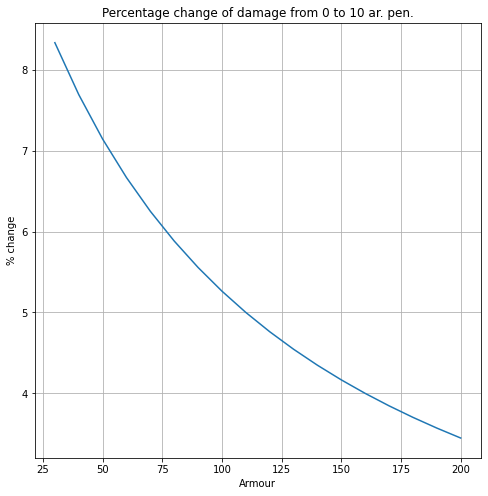

In [ ]:
Attacker = Item(18, 0, 0, 0)
Attacker.ad = 100

armour = np.arange(30,210,10)
temp = np.zeros([*armour.shape])
for ar_idx, ar_val in enumerate(armour):
  temp[ar_idx] = ((dmg_received(100, Champ(1000, ar_val), Item(18, 0, 0, 10))/dmg_received(100, Champ(1000, ar_val), Item(18, 0, 0, 0)))-1)*100

plt.figure(figsize=(8,8))
plt.plot(armour, temp)
plt.ylabel("% change")
plt.xlabel("Armour")
plt.title("Percentage change of damage from 0 to 10 ar. pen.")
plt.grid()


In [ ]:
class Champ:
  def __init__(self, max_hp, mr:float=0.):
    self.max_hp = max_hp
    self.mr = mr

class APitem:
  def __init__(self, ap, mpen, mpen_flat):
    self.ap = ap
    self.mpen = mpen
    self.mpen_flat = mpen_flat

  def dmg_received(self, dmg_receiver: Champ, dmnc:bool=False, melee:bool = False):
    eff_mr = (dmg_receiver.mr * (1 - self.mpen)) - self.mpen_flat
    spell_damage_raw = 100 + self.ap

    if dmnc:
      if melee:
        spell_damage_raw += 0.072 * dmg_receiver.max_hp
      else:
        spell_damage_raw += 0.04 * dmg_receiver.max_hp

    if eff_mr < 0:
      factor = 2 - 100/(100 - eff_mr)
    else:
      factor = 100/(100 + eff_mr)  

    return spell_damage_raw*factor
  
  def deathcap_passive(self):
    self.ap = self.ap * 1.35
  
  def echo(self):
    return 

In [ ]:
N_hp = 7
N_ap = 14
#N_mr = 

C_HP = np.linspace(10, 20, 11, endpoint=True)
AP = np.linspace(0, 260, N_ap)
MR = np.array([50,100,150])
MAX_HP = np.linspace(1000, 4000, N_hp, endpoint=True)

void_st = np.zeros([11, N_ap, 3, N_hp])
dcap_st = np.zeros([11, N_ap, 3, N_hp])
demon_st = np.zeros([11, N_ap, 3, N_hp])
demon_melee = np.zeros([11, N_ap, 3, N_hp])
shadow_st = np.zeros([11, N_ap, 3, N_hp])

for c_idx, c_val in enumerate(C_HP):
  for ap_idx, ap_val in enumerate(AP):
    DCAP = APitem(120 + ap_val, 0, 0)
    DCAP.deathcap_passive()

    VOID = APitem(65 + ap_val, 0.4, 0)
    SHADOW = APitem(100 + ap_val, 0, c_val)
    DEMONIC = APitem(69 + ap_val, 0, 0)

    for mr_idx, mr_val in enumerate(MR):
      for hp_idx, hp_val in enumerate(MAX_HP):
        Victim = Champ(hp_val, mr_val)
        #Values rounded
        dcap_st[c_idx, ap_idx, mr_idx, hp_idx] = DCAP.dmg_received(Victim)
        void_st[c_idx, ap_idx, mr_idx, hp_idx] = VOID.dmg_received(Victim)
        shadow_st[c_idx, ap_idx, mr_idx, hp_idx] = SHADOW.dmg_received(Victim)
        demon_st[c_idx, ap_idx, mr_idx, hp_idx] = DEMONIC.dmg_received(Victim, dmnc=True)
        demon_melee[c_idx, ap_idx, mr_idx, hp_idx] = DEMONIC.dmg_received(Victim, dmnc=True, melee=True)
      

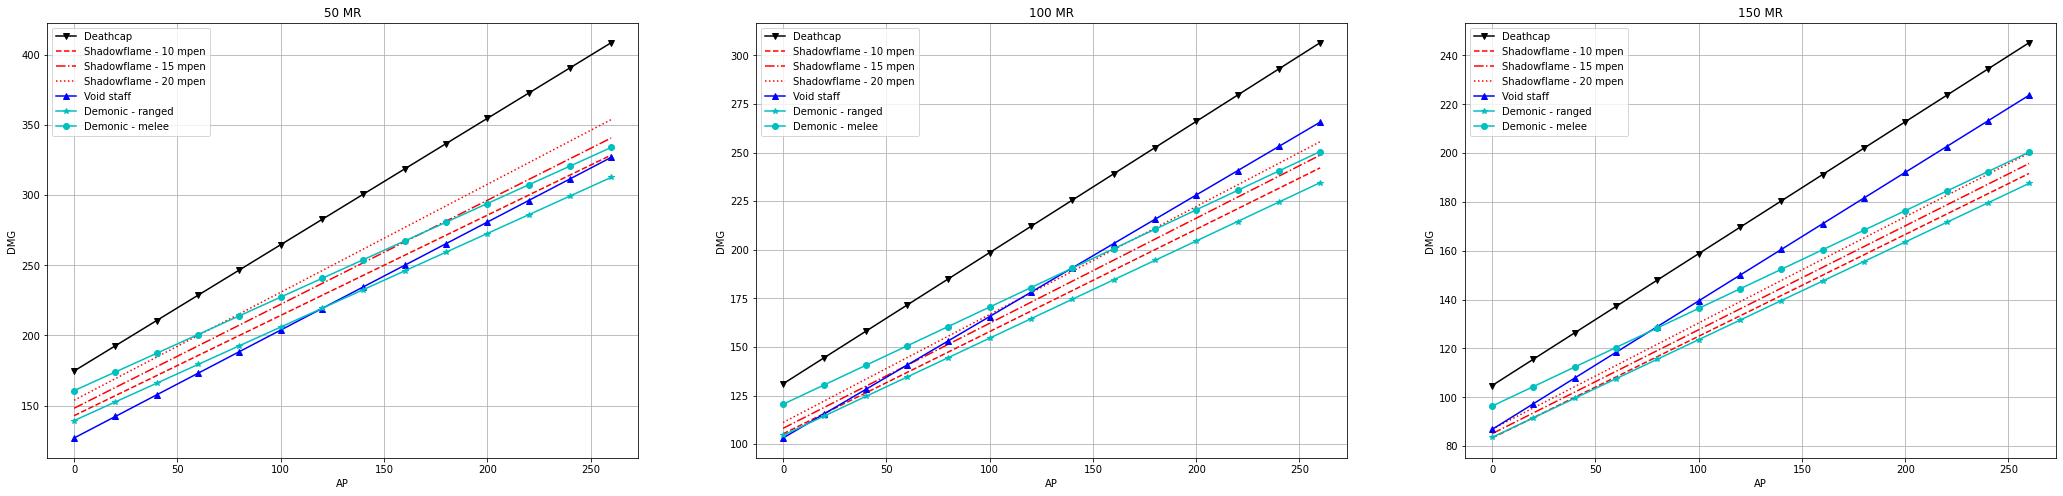

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(36,8))
for i in range(3):
  ax[i].plot(AP, dcap_st[0,:,i,0],"k-v" ,label="Deathcap")
  ax[i].plot(AP, shadow_st[0,:,i,0], "r--",label="Shadowflame - 10 mpen")
  ax[i].plot(AP, shadow_st[5,:,i,0],"r-.",label="Shadowflame - 15 mpen")
  ax[i].plot(AP, shadow_st[10,:,i,0],"r:", label="Shadowflame - 20 mpen")
  ax[i].plot(AP, void_st[0,:,i,0], "b-^",label="Void staff")
  ax[i].plot(AP, demon_st[0,:,i,0],"c-*",label="Demonic - ranged")
  ax[i].plot(AP, demon_melee[0,:,i,0],"c-o", label="Demonic - melee")
  
  ax[i].legend()
  ax[i].grid()
  ax[i].set_ylabel("DMG")
  ax[i].set_xlabel("AP")
  ax[i].set_title(f"{MR[i]} MR")

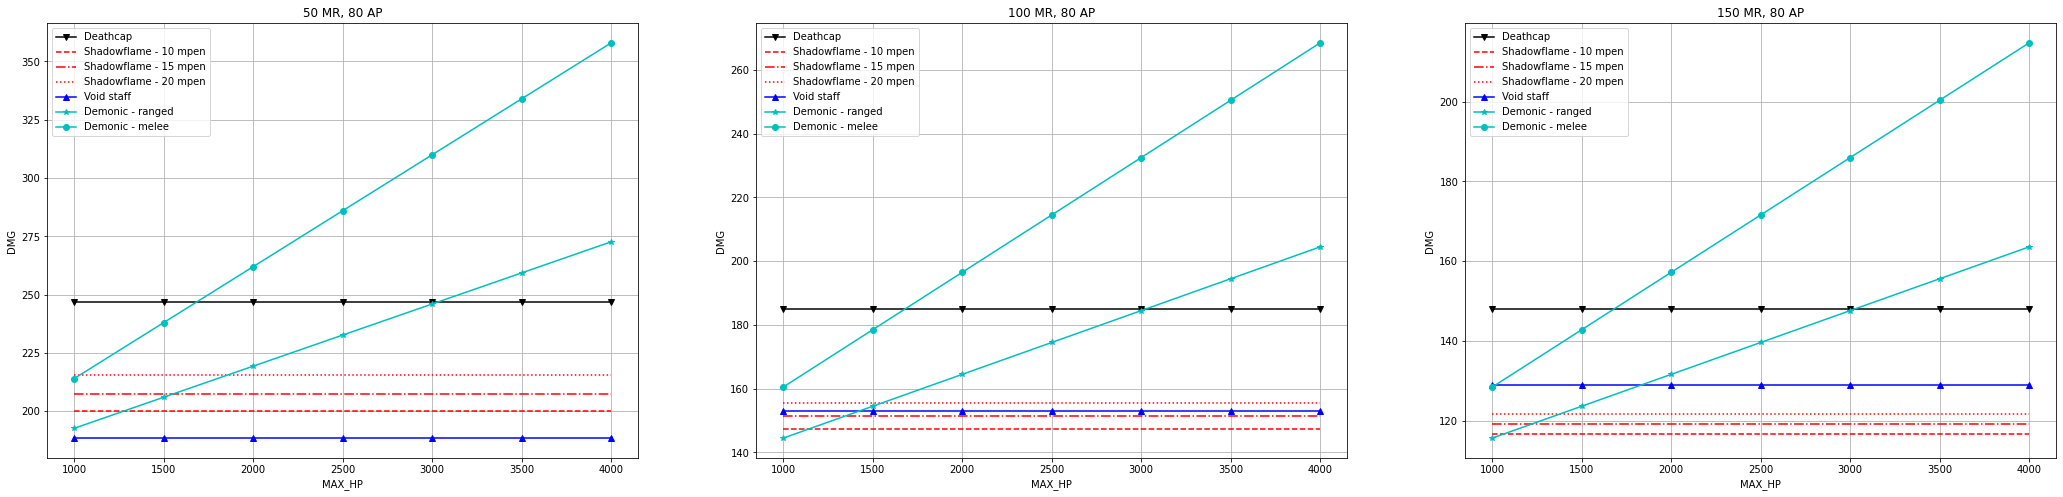

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(36,8))
for i in range(3):
  ax[i].plot(MAX_HP, dcap_st[0,4,i,:],"k-v" ,label="Deathcap")
  ax[i].plot(MAX_HP, shadow_st[0,4,i,:], "r--",label="Shadowflame - 10 mpen")
  ax[i].plot(MAX_HP, shadow_st[5,4,i,:],"r-.",label="Shadowflame - 15 mpen")
  ax[i].plot(MAX_HP, shadow_st[10,4,i,:],"r:", label="Shadowflame - 20 mpen")
  ax[i].plot(MAX_HP, void_st[0,4,i,:], "b-^",label="Void staff")
  ax[i].plot(MAX_HP, demon_st[0,4,i,:],"c-*",label="Demonic - ranged")
  ax[i].plot(MAX_HP, demon_melee[0,4,i,:],"c-o", label="Demonic - melee")
  
  ax[i].legend()
  ax[i].grid()
  ax[i].set_ylabel("DMG")
  ax[i].set_xlabel("MAX_HP")
  ax[i].set_title(f"{MR[i]} MR, 80 AP")

In [ ]:
class Champ:
  def __init__(self, max_hp, mr:float=0.):
    self.max_hp = max_hp
    self.mr = mr

class APitem:
  def __init__(self, ap, mpen, mpen_flat):
    self.ap = ap
    self.mpen = mpen
    self.mpen_flat = mpen_flat
    self.spell_damage_raw = 100 + self.ap

  def dmg_received(self, dmg_receiver: Champ):
    eff_mr = (dmg_receiver.mr * (1 - self.mpen)) - self.mpen_flat

    if eff_mr < 0:
      factor = 2 - 100/(100 - eff_mr)
    else:
      factor = 100/(100 + eff_mr)  

    return self.spell_damage_raw*factor
  
  def deathcap_passive(self):
    self.ap = self.ap * 1.35
  
  def echo(self):
    self.spell_damage_raw += 100 + 0.1*self.ap
  
  def torment(self, dmg_receiver: Champ):
    self.spell_damage_raw += 50 + 0.06*self.ap + 0.04*dmg_receiver.max_hp

In [ ]:
Luden = APitem(80, 0, 6)
Victim = Champ(2000, 100)
Luden.echo()
Luden.dmg_received(Victim)

148.45360824742266

In [ ]:
Liandry = APitem(80, 0, 0)
Liandry.torment(Victim)
Liandry.dmg_received(Victim)

157.4

In [ ]:
N_hp = 11
N_ap = 14

M_PEN = 6 + np.linspace(0, 25, 6, endpoint=True)
AP = np.linspace(0, 260, N_ap)
MR = np.array([50,100,150])
MAX_HP = np.linspace(1000, 4000, N_hp, endpoint=True)

luden_st = np.zeros([6, N_ap, 3, N_hp])
liandry_st = np.zeros([6, N_ap, 3, N_hp])

for m_idx, m_val in enumerate(M_PEN):
  for ap_idx, ap_val in enumerate(AP):
    Luden = APitem(80 + ap_val, 0, 18 + m_val)
    Luden.echo()
    for mr_idx, mr_val in enumerate(MR):
      for hp_idx, hp_val in enumerate(MAX_HP):
        Victim = Champ(hp_val, mr_val)
        Liandry = APitem(80 + ap_val, 0, 18)
        Liandry.torment(Victim)
        #Values rounded
        luden_st[m_idx, ap_idx, mr_idx, hp_idx] = Luden.dmg_received(Victim)
        liandry_st[m_idx, ap_idx, mr_idx, hp_idx] = Liandry.dmg_received(Victim)*1.012

In [ ]:
80 + AP

array([ 80., 100., 120., 140., 160., 180., 200., 220., 240., 260., 280.,
       300., 320., 340.])

In [ ]:
np.linspace(1000, 2500, 6, endpoint=True)

array([1000., 1300., 1600., 1900., 2200., 2500.])

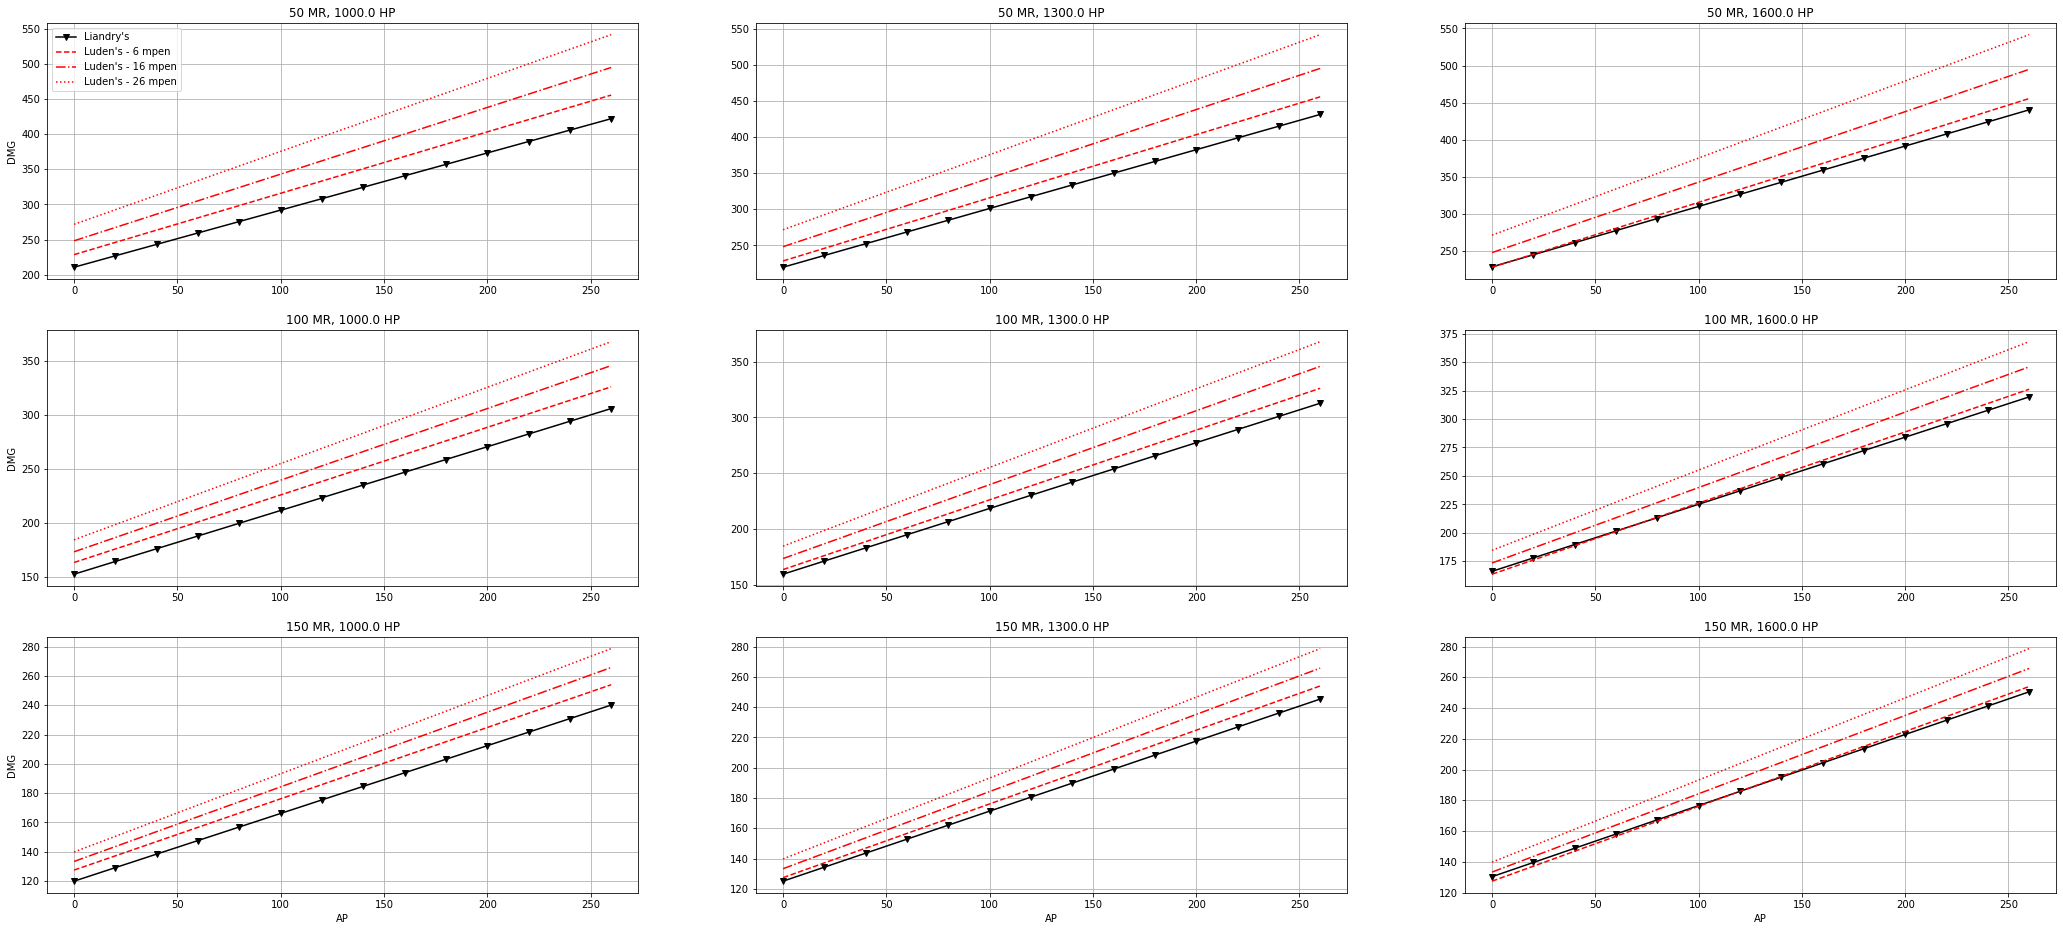

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(36,16))
n = 0
for i in range(3):
  for j in range(3):
    ax[i,j].plot(AP, liandry_st[0,:,i,j+n],"k-v" ,label="Liandry's")
    ax[i,j].plot(AP, luden_st[0,:,i,j+n], "r--",label="Luden's - 6 mpen")
    ax[i,j].plot(AP, luden_st[2,:,i,j+n],"r-.",label="Luden's - 16 mpen")
    ax[i,j].plot(AP, luden_st[4,:,i,j+n],"r:", label="Luden's - 26 mpen")

    ax[i,j].set_title(f"{MR[i]} MR, {MAX_HP[j+n]} HP")
    ax[i,j].grid()
  ax[j,i].set_xlabel("AP")
  ax[0,0].legend()
  ax[i,0].set_ylabel("DMG")

In [ ]:
M_PEN[5]

31.0